<a href="https://www.kaggle.com/code/samamostafa03/genres-and-styles-classification?scriptVersionId=226385087" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Core Libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, get_worker_info, WeightedRandomSampler
import timm
from timm.data import Mixup
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from tqdm.notebook import tqdm
import gc
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.preprocessing import label_binarize
from PIL import Image
sns.set(style='white', context='notebook', palette='deep')

WikiArt Dataset:

In [2]:
# Load and map genres, styles classes
datapath = '/kaggle/input/wikiart'
genres_datapath = '/kaggle/input/genres-ds'
styles_datapath = '/kaggle/input/style-ds'

def process_classes(data_path,file_name):
    file_path =  data_path+'/'+file_name+'.txt'
    classes = {}
    with open(file_path, 'r') as f:
        for line in f:
            index, label = line.strip().split(' ', 1)
            classes[int(index)] = label
    return classes

genres_classes = process_classes(genres_datapath,'genre_class')
styles_classes = process_classes(styles_datapath,'style_class')
print(f"Genres:\n{genres_classes}\n")
print(f"Styles:\n{styles_classes}")

Genres:
{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}

Styles:
{0: 'Abstract_Expressionism', 1: 'Action_painting', 2: 'Analytical_Cubism', 3: 'Art_Nouveau', 4: 'Baroque', 5: 'Color_Field_Painting', 6: 'Contemporary_Realism', 7: 'Cubism', 8: 'Early_Renaissance', 9: 'Expressionism', 10: 'Fauvism', 11: 'High_Renaissance', 12: 'Impressionism', 13: 'Mannerism_Late_Renaissance', 14: 'Minimalism', 15: 'Naive_Art_Primitivism', 16: 'New_Realism', 17: 'Northern_Renaissance', 18: 'Pointillism', 19: 'Pop_Art', 20: 'Post_Impressionism', 21: 'Realism', 22: 'Rococo', 23: 'Romanticism', 24: 'Symbolism', 25: 'Synthetic_Cubism', 26: 'Ukiyo_e'}


In [3]:
# Load train and validation data
genre_data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
genre_data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
genre_data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [4]:
style_data_valid = pd.read_csv(
    styles_datapath + '/style_val.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train = pd.read_csv(
    styles_datapath + '/style_train.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train.head()

,filename,style
0,Impressionism/edgar-degas_landscape-on-the-orn...,12
1,Realism/camille-corot_mantes-cathedral.jpg,21
2,Abstract_Expressionism/gene-davis_untitled-197...,0
3,Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg,24
4,Impressionism/maurice-prendergast_paris-boulev...,12


In [5]:
# Merge datasets on filename (assuming filenames are unique and match)
data_train = pd.merge(genre_data_train, style_data_train, on='filename', suffixes=('_genre', '_style'))
data_valid = pd.merge(genre_data_valid , style_data_valid , on='filename', suffixes=('_genre', '_style'))
data_train.head()

,filename,genre,style
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,20
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,24
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,9
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,9


In [6]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename    0
genre       0
style       0
dtype: int64

validation:
filename    0
genre       0
style       0
dtype: int64


In [7]:
# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 421
Number of invalid files in valid data: 191


In [8]:
# Remove invalid filenames from both train and validation datasets
data_train_cleaned = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train_cleaned)}")

data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid_cleaned)}")


Number of valid rows in train after cleaning: 44868
Number of valid rows in valid after cleaning: 19149


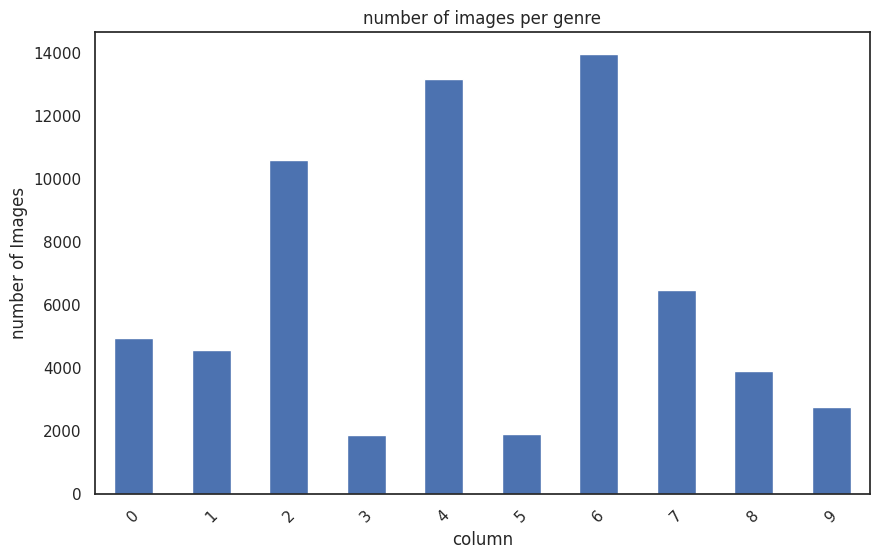

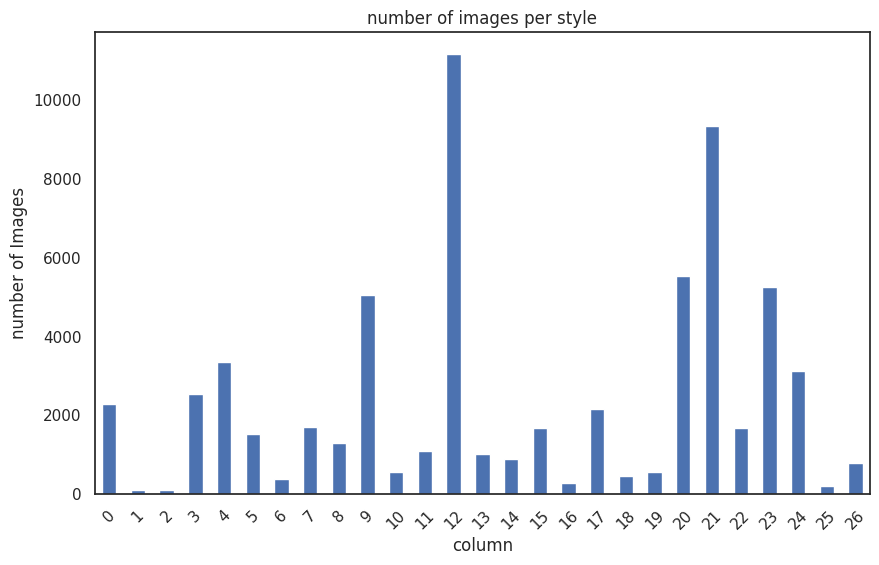

In [9]:
# Visualize the genres , styles distribution
def visualize_data(data_train,data_val,column,classes):
    combined_data = (data_train_cleaned[column].value_counts() + data_valid_cleaned[column].value_counts())
    combined_data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title(f"number of images per {column}")
    plt.ylabel("number of Images")
    plt.xlabel('column')
    plt.xticks(rotation=45)
    plt.show()
visualize_data(data_train_cleaned,data_valid_cleaned,'genre',genres_classes)
visualize_data(data_train_cleaned,data_valid_cleaned,'style',styles_classes)

In [10]:
# Split the data into training, validation and testing sets (80% train, 10% validation, 10% test)
train_data, data_temp = train_test_split(data_train_cleaned, test_size=0.30, random_state=42, stratify=data_train_cleaned['genre'])
valid_data, test_data = train_test_split(data_temp, test_size=1/2, random_state=42, stratify=data_temp['genre'])
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(31407, 3)
(6730, 3)
(6731, 3)


In [21]:
# Clear Cache & Set Device
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import argparse
from datetime import datetime
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f'art_classification_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'),
        logging.StreamHandler()
    ]
)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class ArtClassifier:
    def __init__(self, data_dir, batch_size=32, img_size=224):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.feature_extractor = None
        self.scaler = None
        self.ensemble = None
        
        # Data augmentation for training
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2],
            validation_split=0.2
        )
        
        # Only rescaling for validation and test
        self.val_datagen = ImageDataGenerator(rescale=1./255)
        self.test_datagen = ImageDataGenerator(rescale=1./255)

    def create_feature_extractor(self):
        """Create and return the feature extraction model."""
        logging.info("Creating feature extractor...")
        base_model = EfficientNetV2L(
            include_top=False,
            weights='imagenet',
            input_shape=(self.img_size, self.img_size, 3)
        )
        
        # Freeze the base model
        base_model.trainable = False
        
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2)
        ])
        
        return model

    def load_data(self):
        """Load and prepare the data generators."""
        logging.info("Loading data...")
        train_generator = self.train_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'train'),
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='categorical',
            subset='training'
        )
        
        val_generator = self.val_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'valid'),
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        
        test_generator = self.test_datagen.flow_from_directory(
            os.path.join(self.data_dir, 'test'),
            target_size=(self.img_size, self.img_size),
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        
        return train_generator, val_generator, test_generator

    def extract_features(self, model, generator):
        """Extract features using the feature extraction model."""
        features = []
        labels = []
        
        for i in range(len(generator)):
            x, y = generator[i]
            features_batch = model.predict(x)
            features.append(features_batch)
            labels.append(y)
        
        features = np.concatenate(features)
        labels = np.concatenate(labels)
        
        return features, labels

    class EnsembleModel:
        def __init__(self):
            self.svm = SVC(kernel='rbf', probability=True)
            self.rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
            self.xgb = xgb.XGBClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=6,
                n_jobs=-1
            )
        
        def fit(self, X, y):
            logging.info("Training SVM...")
            self.svm.fit(X, y)
            
            logging.info("Training Random Forest...")
            self.rf.fit(X, y)
            
            logging.info("Training XGBoost...")
            self.xgb.fit(X, y)
        
        def predict_proba(self, X):
            svm_proba = self.svm.predict_proba(X)
            rf_proba = self.rf.predict_proba(X)
            xgb_proba = self.xgb.predict_proba(X)
            
            # Weighted ensemble
            ensemble_proba = 0.4 * svm_proba + 0.3 * rf_proba + 0.3 * xgb_proba
            return ensemble_proba
        
        def predict(self, X):
            return np.argmax(self.predict_proba(X), axis=1)

    def train(self):
        """Main training pipeline."""
        try:
            # Load data
            train_gen, val_gen, test_gen = self.load_data()
            
            # Create and train feature extractor
            self.feature_extractor = self.create_feature_extractor()
            
            # Extract features
            logging.info("Extracting training features...")
            X_train, y_train = self.extract_features(self.feature_extractor, train_gen)
            
            logging.info("Extracting validation features...")
            X_val, y_val = self.extract_features(self.feature_extractor, val_gen)
            
            logging.info("Extracting test features...")
            X_test, y_test = self.extract_features(self.feature_extractor, test_gen)
            
            # Scale features
            logging.info("Scaling features...")
            self.scaler = StandardScaler()
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_val_scaled = self.scaler.transform(X_val)
            X_test_scaled = self.scaler.transform(X_test)
            
            # Train ensemble model
            logging.info("Training ensemble model...")
            self.ensemble = self.EnsembleModel()
            self.ensemble.fit(X_train_scaled, np.argmax(y_train, axis=1))
            
            # Evaluate
            logging.info("Evaluating model...")
            val_pred = self.ensemble.predict(X_val_scaled)
            test_pred = self.ensemble.predict(X_test_scaled)
            
            val_acc = accuracy_score(np.argmax(y_val, axis=1), val_pred)
            test_acc = accuracy_score(np.argmax(y_test, axis=1), test_pred)
            
            logging.info(f"Validation Accuracy: {val_acc:.4f}")
            logging.info(f"Test Accuracy: {test_acc:.4f}")
            
            # Save results
            self.save_results(val_acc, test_acc)
            
            return val_acc, test_acc
            
        except Exception as e:
            logging.error(f"Error during training: {str(e)}")
            raise

    def save_results(self, val_acc, test_acc):
        """Save model results and metrics."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save metrics
        metrics = {
            'validation_accuracy': val_acc,
            'test_accuracy': test_acc,
            'timestamp': timestamp
        }
        
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv(f'metrics_{timestamp}.csv', index=False)
        
        logging.info(f"Results saved with timestamp: {timestamp}")

def main():
    parser = argparse.ArgumentParser(description='Train art classification model')
    parser.add_argument('--data_dir', type=str, required=True, help='Path to the data directory')
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training')
    parser.add_argument('--img_size', type=int, default=224, help='Image size for input')
    
    args = parser.parse_args()
    
    # Create classifier instance
    classifier = ArtClassifier(
        data_dir=args.data_dir,
        batch_size=args.batch_size,
        img_size=args.img_size
    )
    
    # Train the model
    classifier.train()

if __name__ == "__main__":
    main() 

In [13]:
from concurrent.futures import ThreadPoolExecutor

train_data["filename"] = train_data["filename"].apply(lambda x: f"{datapath}/{x}")
valid_data["filename"] = valid_data["filename"].apply(lambda x: f"{datapath}/{x}")

image_paths_train = train_data["filename"].tolist()
labels_train = train_data["style"].tolist()

image_paths_valid = valid_data["filename"].tolist()
labels_valid = valid_data["style"].tolist()
num_gpus = 2

In [22]:
# Load Pretrained ViT model (without classification head)
vit = models.vit_b_16(pretrained=True)  # You can also try vit_l_16 for a larger model
vit.heads = torch.nn.Identity()  # Remove the classification layer
vit = torch.nn.DataParallel(vit)  # Use multiple GPUs
vit.to(device)
vit.eval()

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract features
def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Move to GPU
    with torch.no_grad():
        features = vit(image)  # Extract features using ViT
    return features.squeeze().cpu().numpy().flatten()  # Move back to CPU

In [23]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        return image, self.labels[idx]

def process_batch(image_paths, labels, output_file, batch_size=32):
    dataset = ImageDataset(image_paths, labels, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    with open(output_file, "w") as f:
        first = True
        for images, batch_labels in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)  # Move batch to GPU
            with torch.no_grad():
                batch_features = vit(images)  # Output shape: (batch_size, 2048, 1, 1)
            batch_features = batch_features.squeeze(-1).squeeze(-1).cpu().numpy()  # Remove (1,1)
            # Convert batch to DataFrame
            df = pd.DataFrame(batch_features)
            df["label"] = batch_labels.numpy()
            # Append to CSV to avoid memory issues
            df.to_csv(output_file, mode="a", header=first, index=False)
            first = False

print("Extracting train features...")
process_batch(image_paths_train, labels_train, "train_features.csv")

print("Extracting validation features...")
process_batch(image_paths_valid, labels_valid, "valid_features.csv")


Extracting train features...


Extracting Features:   0%|          | 0/982 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Extracting Features: 100%|██████████| 982/982 [10:45<00:00,  1.52it/s]


Extracting validation features...


Extracting Features:   0%|          | 0/211 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Extracting Features: 100%|██████████| 211/211 [02:17<00:00,  1.53it/s]


In [24]:
df_train_iter = pd.read_csv("train_features.csv", chunksize=5000)  # Load in chunks
df_valid_iter = pd.read_csv("valid_features.csv", chunksize=5000)

X_train, y_train = [], []
for chunk in df_train_iter:
    y_train.extend(chunk["label"].values)
    X_train.append(chunk.iloc[:, :-1].values)  # Features

X_valid, y_valid = [], []
for chunk in df_valid_iter:
    y_valid.extend(chunk["label"].values)
    X_valid.append(chunk.iloc[:, :-1].values)  # Features

X_train = np.vstack(X_train)
X_valid = np.vstack(X_valid)


In [25]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm  # For progress bar
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import joblib

# Load extracted features
df_train = pd.read_csv("train_features.csv")
df_valid = pd.read_csv("valid_features.csv")

# Separate features and labels
X_train = df_train.iloc[:, :-1].values
y_train = df_train["label"].values
X_valid = df_valid.iloc[:, :-1].values
y_valid = df_valid["label"].values

# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)

# Standardize features before PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Apply PCA
pca_components = min(512, X_train.shape[1])
pca = PCA(n_components=pca_components)
X_train = pca.fit_transform(X_train)
X_valid = pca.transform(X_valid)

# 🔹 Train SVM with verbose output
print("\nTraining SVM...")
svm = SVC(kernel="rbf", C=1.0, probability=True, verbose=True)  # Enable training progress
svm.fit(X_train, y_train)

# Save models
joblib.dump(svm, "svm_model.pkl")

# Evaluate model
svm_acc = accuracy_score(y_valid, svm.predict(X_valid))

print(f"SVM Accuracy: {svm_acc * 100:.2f}%")


Training SVM...
[LibSVM]SVM Accuracy: 56.48%
